In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from keras import models, layers
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras_unet.models import satellite_unet as unetModel
from skimage.morphology import label
import gc 
import cv2
from keras_unet.utils import plot_segm_history

In [2]:
### path initialisation
trainImagesPath = os.path.join('../input', 'train_v2/')
testImagesPath = os.path.join('../input', 'test_v2/')

In [32]:
## run length encoding-decoding and mask image generation

def decodeRle(rleMask):
    rleMask = rleMask.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (rleMask[0:][::2], rleMask[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(768*768, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(768,768).T


def generateMaskImage(masksList):
    maskImage = np.zeros(shape=(768,768))
    for mask in masksList:
        decodedMask = decodeRle(mask)
        maskImage+=decodedMask
    return maskImage

In [4]:
## training csv file read
masks = pd.read_csv(os.path.join('../input/',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


Total images having ships : 42556

Number of Images having different number of ships



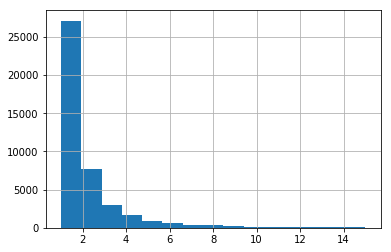

In [5]:
## distribution of ship images having different number of ships and data balancing
trainCsv = pd.read_csv("/kaggle/input/train_ship_segmentations_v2.csv")
shipsCsv = trainCsv
shipCsv = shipsCsv.dropna()
shipsCount = shipCsv.groupby(['ImageId'], sort=True).size().reset_index(name='Count')
print("Total images having ships :", len(shipsCount))
print("\nNumber of Images having different number of ships\n")
shipsCount["Count"].hist(bins=shipsCount['Count'].max())
shipsCount.sort_values("Count", axis = 0, ascending = False, inplace = True, na_position ='last') 



In [6]:
## dataset generation after balancing
def generateDataSet():
    trainImages = []
    testImages = []
    maxShipsCount = 15
    for i in range(1, maxShipsCount+1):
        n = shipsCount["Count"].loc[shipsCount["Count"]==i].count()
        print(i,n)
        trainCount = int(90*n/100)
        images = list(shipsCount["ImageId"].loc[shipsCount["Count"]==i])

        for imageName in images[:trainCount]:
            trainImages.append(imageName)
        for imageName in images[trainCount:]:
            testImages.append(imageName) 
            
    return trainImages, testImages

## adding images having no ships
def addNoShipImages(trainImages, testImages):
    noShipsCsv =trainCsv[trainCsv['EncodedPixels'].isnull()]
    noShipsImages = noShipsCsv.ImageId.tolist()
    trainImages = trainImages + noShipsImages[:2000]
    testImages = testImages + noShipsImages[2000:2200]
    return trainImages, testImages

In [7]:
trainImages, testImages = generateDataSet()
trainImages, testImages = addNoShipImages(trainImages, testImages)

1 27104
2 7674
3 2954
4 1622
5 925
6 657
7 406
8 318
9 243
10 168
11 144
12 124
13 75
14 76
15 66


In [8]:
print(len(trainImages), len(testImages))

40293 4463


In [24]:
## RAM memory issue thats why batch generator used,  keras_fir geneartor does data augmentation as well, loads data in batches
          
def imageGenerator(images, batchSize = 1):
    samples = []
    masks = []
    count = 0
    for i, imageName in enumerate(images):
        image = cv2.imread(trainImagesPath + imageName)
        masksList = trainCsv.loc[trainCsv["ImageId"]==imageName]["EncodedPixels"]
        maskImage = generateMaskImage(masksList)
        maskImage = maskImage.reshape(768,768,1)
        samples.append(image)
        masks.append(maskImage)
        
        count+=1
        if(count%batchSize==0):
#             print("batch", count)
            yield np.array(samples), np.array(masks)
            samples = []
            masks = []


In [10]:
## train data generator
trainGenerator = imageGenerator(trainImages[:200], batchSize=4)
trainSamples, trainMasks = next(trainGenerator)
## test data generator
testGenerator = imageGenerator(trainImages[:20], batchSize=20)
testSamples, testMasks = next(testGenerator)
print(trainSamples.shape, trainMasks.shape)
print(testSamples.shape, testMasks.shape)

(4, 768, 768, 3) (4, 768, 768, 1)
(20, 768, 768, 3) (20, 768, 768, 1)


In [11]:
### images raw pixels and mask generator for batch training, yields a batch sized training samples and masks at a time
sampleGenerator = ImageDataGenerator(rotation_range=20,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.25)

maskGenerator = ImageDataGenerator(rotation_range=20,
    zoom_range=0.25,
    shear_range=0.15,
    horizontal_flip=True,
    width_shift_range=0.3,
    height_shift_range=0.25)
            
def augmentData(generator):
    for samples, masks in generator:
        augSamples = sampleGenerator.flow(255*samples, 
                             batch_size = samples.shape[0], 
                             seed = np.random.choice(range(10000)), 
                             shuffle=True)
        augMasks = maskGenerator.flow(masks, 
                             batch_size = samples.shape[0], 
                             seed = np.random.choice(range(10000)), 
                             shuffle=True)

        yield next(augSamples)/255.0, next(augMasks)

Using TensorFlow backend.


In [ ]:
## evaluation metric for model: Intersection over union
def IoU(trueMask, predMask):
    if np.max(trueMask) == 0.0:
        return IoU(1-trueMask, 1-predMask)
    intersect = np.sum(trueMask * predMask)
    union = np.sum(trueMask) + np.sum(predMask) - intersect
    return -np.mean( (intersect) / (union), axis=0)

In [55]:
## UNET model architecture defined; loaded; compiled; loss and evaluation metric defined
model = unetModel(input_shape=trainSamples.shape[1:])
model.summary()
model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=binary_crossentropy, metrics=['binary_accuracy',  IoU])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
conv2d_113 (Conv2D)             (None, 768, 768, 64) 1792        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_125 (BatchN (None, 768, 768, 64) 256         conv2d_113[0][0]                 
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 768, 768, 64) 36928       batch_normalization_125[0][0]    
__________________________________________________________________________________________________
batch_norm

In [57]:
### model training in batches, batch size = 4, data augmentation; run again for less number of epochs and steps to get output
history = model.fit_generator(augmentData(imageGenerator(trainImages)), 
                             steps_per_epoch=100, 
                             epochs=10, 
                             validation_data=(testSamples, testMasks))

Epoch 1/10
100/100 [==============================] - 37s 373ms/step - loss: 0.0244 - binary_accuracy: 0.9963 - IoU: -0.0013 - val_loss: 4.5366 - val_binary_accuracy: 0.7136 - val_IoU: -0.0039
Epoch 2/10
100/100 [==============================] - 34s 335ms/step - loss: 0.0282 - binary_accuracy: 0.9956 - IoU: -0.0024 - val_loss: 15.8251 - val_binary_accuracy: 0.0074 - val_IoU: -0.0052
Epoch 3/10
100/100 [==============================] - 35s 349ms/step - loss: 0.0270 - binary_accuracy: 0.9959 - IoU: -0.0012 - val_loss: 4.7200 - val_binary_accuracy: 0.6977 - val_IoU: -0.0053
Epoch 4/10
100/100 [==============================] - 35s 349ms/step - loss: 0.0276 - binary_accuracy: 0.9958 - IoU: -0.0013 - val_loss: 14.2892 - val_binary_accuracy: 0.0978 - val_IoU: -0.0051
Epoch 5/10
100/100 [==============================] - 34s 345ms/step - loss: 0.0217 - binary_accuracy: 0.9968 - IoU: -8.1948e-04 - val_loss: 6.8984 - val_binary_accuracy: 0.5635 - val_IoU: -0.0059
Epoch 6/10
100/100 [=========

In [58]:
print(history.history)

{'val_loss': [4.536631798744201, 15.82508373260498, 4.720003974437714, 14.289153385162354, 6.898370575904846, 12.649037289619447, 1.5047234505414964, 10.929503655433654, 0.2027351248078048, 0.13661132995039224], 'val_binary_accuracy': [0.7135840445756912, 0.007350328261964023, 0.6976617604494095, 0.09777526743710041, 0.5634862229228019, 0.19924808088690044, 0.9022894978523255, 0.3091570584103465, 0.9861785918474197, 0.9914716929197311], 'val_IoU': [-0.0038680293149809587, -0.005186535371467471, -0.005295070359352394, -0.005124020392031525, -0.005946980466978858, -0.005232375238847453, -0.0032106024307722693, -0.003090129854172119, -0.00039392265314840277, -8.916315387650156e-05], 'loss': [0.02440908975666389, 0.02822939755162224, 0.027029150668531655, 0.027594071263447404, 0.021734026977792382, 0.025695281089283525, 0.028009371964726595, 0.026038275975733997, 0.026948781029786914, 0.019760975722456352], 'binary_accuracy': [0.9963386708498001, 0.9956035375595093, 0.9958598834276199, 0.9

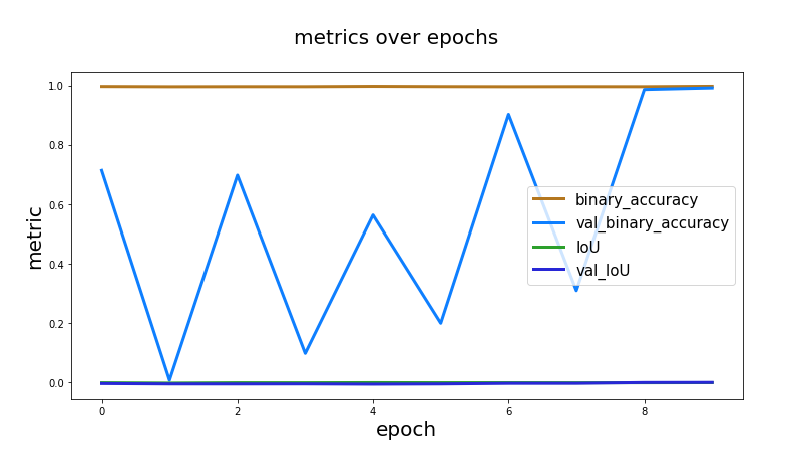

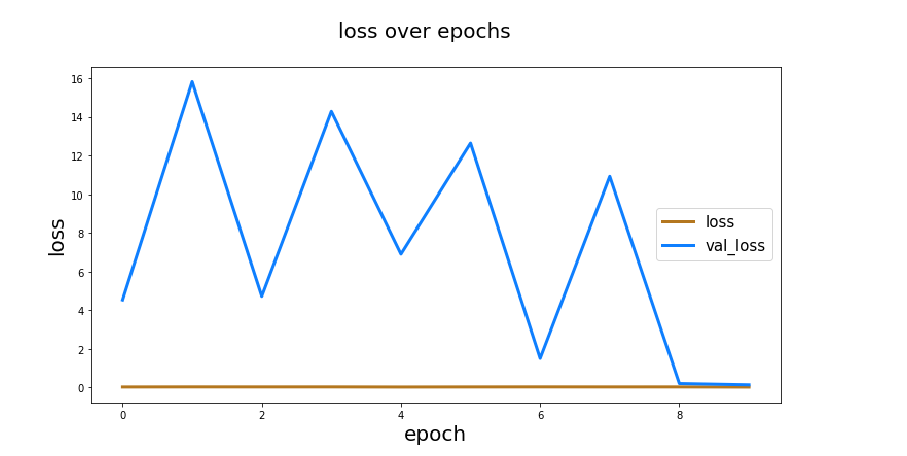

In [20]:
plot_segm_history(
    history,
    metrics=['binary_accuracy',  'val_binary_accuracy', 'IoU','val_IoU'],
    losses=['loss', 'val_loss']) 

In [21]:
### load and save model
from keras.models import load_model
from keras.models import model_from_json
model_json = fullres_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
fullres_model.save_weights("model.h5")


json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")




Loaded model from disk


In [31]:
def getBBoxFromMask(maskImage):
    labels = label(maskImage) 
    coordinates = regionprops(labels)
    return coordinates

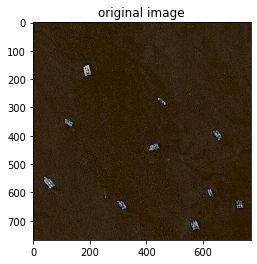

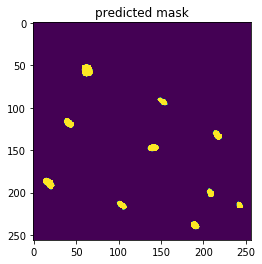

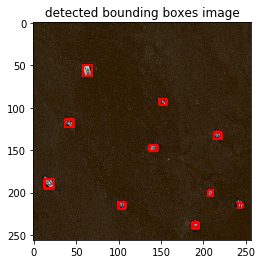

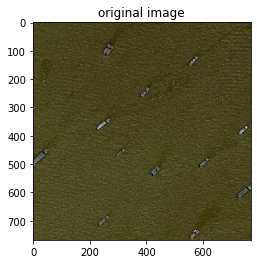

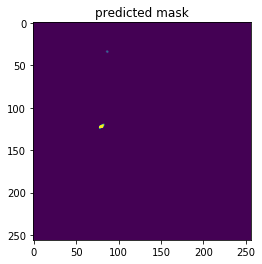

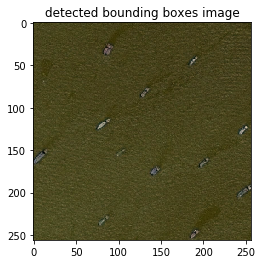

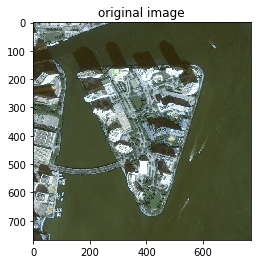

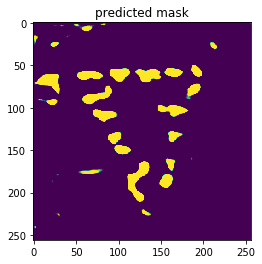

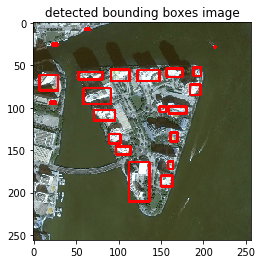

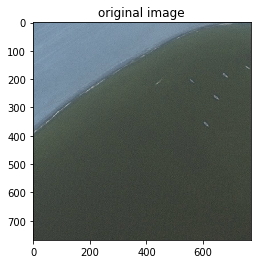

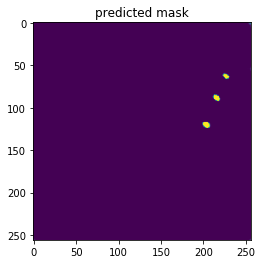

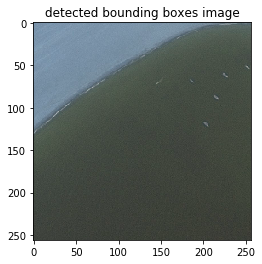

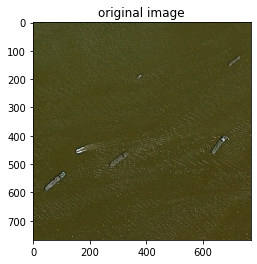

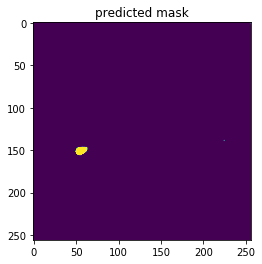

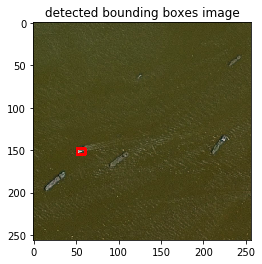

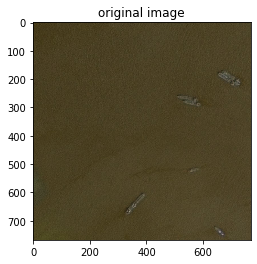

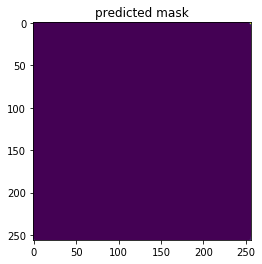

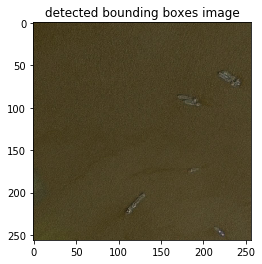

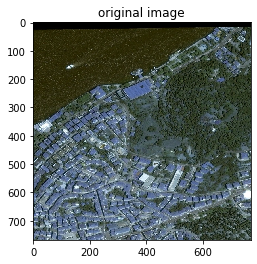

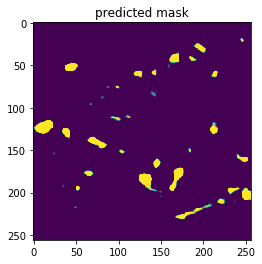

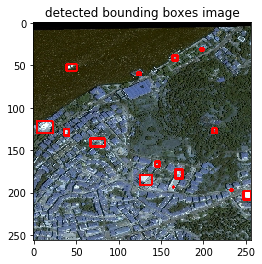

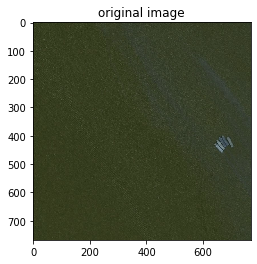

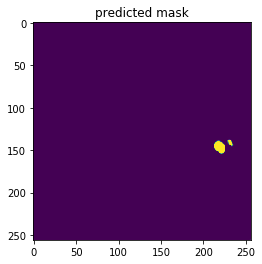

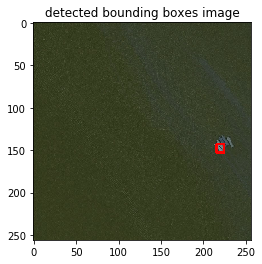

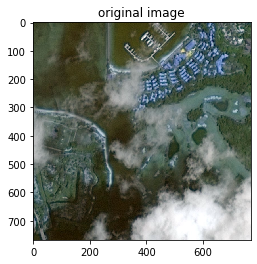

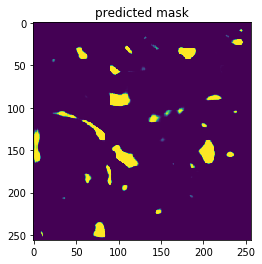

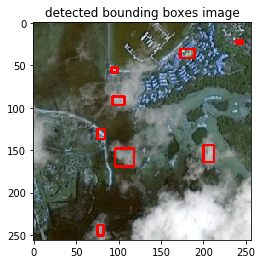

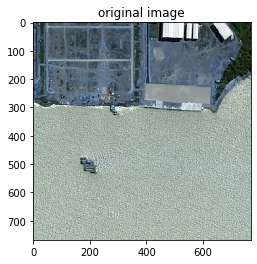

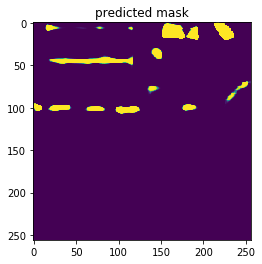

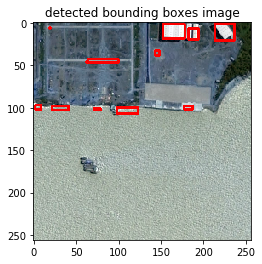

In [43]:
import os
import numpy as np
from skimage.measure import label, regionprops

count = 0
testImagesPath = "C:/Users\K\Desktop\ZAKI  FOLDER\mtech\sml\project\code\ships_small_dataset/test/"
for dir, _, files in os.walk(testImagesPath):
    for file in files[10:20]:
        path = os.path.join(testImagesPath, file)
        image = cv2.imread(path)
        plt.figure()
        plt.title('original image')
        plt.imshow(image)
        image = cv2.resize(image, (256, 256))
        image = np.expand_dims(image, 0)/255.0
        predictedMask = loaded_model.predict(image)
        plt.figure()
        plt.imshow(predictedMask[0,:,:, 0])
        plt.title('predicted mask')
        coords = getBBoxFromMask(predictedMask[0,:,:, 0])
        image = cv2.imread(path)
        image = cv2.resize(image, (256, 256))
        for coord in coords:
            cv2.rectangle(image, (coord.bbox[1], coord.bbox[0]), (coord.bbox[3], coord.bbox[2]), (255, 0, 0), 2)
        plt.figure()
        plt.title('detected bounding boxes image')
        plt.imshow(image)        


In [42]:
import warnings
warnings.filterwarnings('ignore')